In [1]:
%matplotlib notebook
import matplotlib
import seaborn as sb
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Jupyter Specifics
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [2]:
from Cluster import *

Getting data:
getting JHU data...
jhu data selected from 1/22/20 to 10/8/20
expanding JHU data : to new (daily), 7-day rolling (smoothed), reporting glitch (corrected) and combined



number of countries listed in JHU database 189
done with JHU data (covid_ts dictionary keys: confirmed, deaths, recovered).
getting owid data...
owid data selected from 1/23/20 to 10/9/20
expanding OWID data : to new (daily), 7-day rolling (smoothed), reporting glitch (corrected) and combined



number of countries listed in OWID database 212
done with OWID data (covid_owid_ts dictionary see .keys()) .
getting ICU and acute care data icus_2012 and WHO ...
WHO acute file found dictionary acute_who
ICU file found dictionary icus_2012
mapping country names between JHU and OWID and extracting common countries...
extracting data sets for common countries both databases...
No of big common countries is 86
---------------------------------
extracting testing data from OWID database
doing piecewise linear fits to testing data ... reg_testing



completed regularization of testing by pwlf and linear adjustment to confirmed cases (linr).
constructing nonlinear adjustment to confirmed cases based on pwlf testing (nonlin and nonlinr ...
completed nonlinear adjustment to confirmed cases.
Done with data.
---------------------------------
Constructing common synchronized deaths, case and testing data...
debug len(total_deaths) 186
debug len(big) 86
synchronizing and trimming time series to common length...
making cases with nonlinear testing adjustment...
done.
to change the nonlinear correction function, call make_cases_adj_nonlin(K), K=2 by default
----------------------------------------
Finished loading Cluster module
----------------------------------------


In [3]:
cases = [c for c in clusdata_all]
datasets = ['deaths','cases','cases_lin2020','cases_pwlfit','cases_nonlin','cases_nonlinr']
countries = d_countries = [c for c in clusdata_all['deaths']]

Covid_19 2020 Consensus Cluster Map

In [4]:
# https://ipyleaflet.readthedocs.io/en/latest/api_reference/choropleth.html
# https://github.com/jupyter-widgets/ipyleaflet/issues/454
# https://github.com/jupyter-widgets/ipyleaflet/blob/master/ipyleaflet/leaflet.py
# https://carpentries-incubator.github.io/jupyter_maps/03-vector/index.html
# https://www.youtube.com/watch?v=wjzAy_yLrdA

In [5]:
import ipyleaflet
import json
import pandas as pd
import geopandas as gpd
import pickle as pk
import numpy as np
import os
import requests
from ipywidgets import link, FloatSlider, HTML
from branca.colormap import linear
from matplotlib import colors as mpcolors

In [6]:
def load_data(url, filename, file_type):
    r = requests.get(url)
    with open(filename, 'w') as f:
        f.write(r.content.decode("utf-8"))
    with open(filename, 'r') as f:
        return file_type(f)

In [7]:
#Setting up the world countries data URL
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_shapes = f'{url}/world-countries.json'
# Loading a json data structure with geo data using json.load: geo_json_data
geo_json_data = load_data(country_shapes,'json',json.load);

In [8]:
fname = country_shapes
geog = gpd.read_file(fname)
geog.head();

In [9]:
with open('clusalign_hsv.pk','rb') as fp:
    clusalign_hsv = pk.load(fp)   
clusalign_hsv;

In [10]:
df0list = [[term]+list(clusalign_hsv[term]) for term in clusalign_hsv]
df0 = pd.DataFrame(df0list, columns = ['name','cluster','hue','sat','val'])

In [11]:
dflist = [[term]+[list(clusalign_hsv[term])[0]]+[list(clusalign_hsv[term])[1:]] for term in clusalign_hsv]
df = pd.DataFrame(dflist, columns = ['name','cluster','hsv'])
df;

In [12]:
df.replace('United States', 'United States of America', inplace=True)
df.replace('USA', "United States of America", inplace = True)
df.replace('Tanzania', "United Republic of Tanzania", inplace = True)
df.replace('Democratic Republic of Congo', "Democratic Republic of the Congo", inplace = True)
df.replace('Congo', "Republic of the Congo", inplace = True)
df.replace('Lao', "Laos", inplace = True)
df.replace('Syrian Arab Republic', "Syria", inplace = True)
df.replace('Serbia', "Republic of Serbia", inplace = True)
df.replace('Czechia', "Czech Republic", inplace = True)
df.replace('UAE', "United Arab Emirates", inplace = True)

In [13]:
geogclus=geog.merge(df,how='left',on='name')

In [14]:
# now add the new properties to geo_json_data
# https://stackoverflow.com/questions/944700/how-can-i-check-for-nan-values
import math
x = float('nan')
print(math.isnan(x))
clusters =  dict(zip(geogclus['id'].tolist(), geogclus['cluster'].tolist()))
clusters = {cc: -1 if math.isnan(clusters[cc]) else clusters[cc] for cc in clusters.keys()}
clusterbn =  dict(zip(geogclus['name'].tolist(), geogclus['cluster'].tolist()))
clusterbn = {cc: -2 if math.isnan(clusterbn[cc]) else clusterbn[cc] for cc in clusterbn.keys()}
hsvbn =  dict(zip(geogclus['name'].tolist(), geogclus['hsv'].tolist()))
hsvbn = {cc: [0.,0.,1.] if not isinstance(hsvbn[cc],list) else hsvbn[cc]  for cc in hsvbn.keys()}

True


In [15]:
# now add cluster and hsv properties to geo_json_data to allow flexible use
for feature in geo_json_data['features']:
    # print(feature)
    properties = feature['properties']
    name = properties['name']
    properties['cluster']= clusterbn[name]
    properties['hsv']= hsvbn[name]
    #print(name,properties['hsv'])

In [16]:
def rgb_to_str(rgb):
    return '#%02x%02x%02x' % (int(rgb[0]*255),int(rgb[1]*255),int(rgb[2]*255))

def colorit(feature,colormap,x):
    h = feature['properties']['hsv'][0]
    s = feature['properties']['hsv'][1]
    v = feature['properties']['hsv'][2]
    rgb = list(mpcolors.hsv_to_rgb([h,s,v]))
    return rgb_to_str(rgb)

style_function = lambda feature,colormap,x: {"weight":0.5, 
                            'color':'black',
                            #'fillColor':colormap(x['properties']['hue']), 
                            'fillColor':colorit(feature,colormap,x), 
                            'fillOpacity':1.0}

In [17]:
def update_html(feature,  **kwargs):
    html.value = '''
        <h3><b>{}</b></h3>
        <h4>Cluster: {:2d} </h4> 
        <h4>HSV: {}</h4>
    '''.format(feature['properties']['name'],
               feature['properties']['cluster'],
               "%.3f %.3f %.3f" % tuple(feature['properties']['hsv']))

In [ ]:
chosen_country = 'Australia'
def update_country(feature, **kwargs):
    global chosen_country
    global plot_corrections
    chosen_country = feature['properties']['name']
    def plot_corrections(country=chosen_country,dtype='deaths',database='jhu')

In [18]:
layer = ipyleaflet.Choropleth(
    geo_data=geo_json_data,
    choro_data=clusters,
    colormap=linear.YlOrRd_04,
    border_color='black',
    style={'fillOpacity': 0.8, 'dashArray': '5, 5'},
    style_callback = style_function)

html = HTML('''Hover Over Countries''')
html.layout.margin = '0px 20px 20px 20px'
control = ipyleaflet.WidgetControl(widget=html, position='topright')

m = ipyleaflet.Map(center = (20,10), zoom = 2)
m.add_layer(layer)

m.add_control(control)
layer.on_hover(update_html)
m.add_control(ipyleaflet.FullScreenControl())

m;

In [19]:
# https://ipyleaflet.readthedocs.io/en/latest/api_reference/choropleth.html
# https://github.com/jupyter-widgets/ipyleaflet/issues/454
# https://github.com/jupyter-widgets/ipyleaflet/blob/master/ipyleaflet/leaflet.py
# https://carpentries-incubator.github.io/jupyter_maps/03-vector/index.html
# https://www.youtube.com/watch?v=wjzAy_yLrdA
# https://ipywidgets.readthedocs.io/en/stable/

import ipyleaflet
import json
import pandas as pd
import geopandas as gpd
import pickle as pk
import numpy as np
import os
import requests
from ipywidgets import link, FloatSlider, HTML
from branca.colormap import linear
from matplotlib import colors as mpcolors

def load_data(url, filename, file_type):
    r = requests.get(url)
    with open(filename, 'w') as f:
        f.write(r.content.decode("utf-8"))
    with open(filename, 'r') as f:
        return file_type(f)

#Setting up the world countries data URL
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_shapes = f'{url}/world-countries.json'
# Loading a json data structure with geo data using json.load: geo_json_data
geo_json_data = load_data(country_shapes,'json',json.load);

fname = country_shapes
geog = gpd.read_file(fname)
geog.head();

with open('clusalign_hsv.pk','rb') as fp:
    clusalign_hsv = pk.load(fp)   
clusalign_hsv;

df0list = [[term]+list(clusalign_hsv[term]) for term in clusalign_hsv]
df0 = pd.DataFrame(df0list, columns = ['name','cluster','hue','sat','val'])

dflist = [[term]+[list(clusalign_hsv[term])[0]]+[list(clusalign_hsv[term])[1:]] for term in clusalign_hsv]
df = pd.DataFrame(dflist, columns = ['name','cluster','hsv'])
df;

df.replace('United States', 'United States of America', inplace=True)
df.replace('USA', "United States of America", inplace = True)
df.replace('Tanzania', "United Republic of Tanzania", inplace = True)
df.replace('Democratic Republic of Congo', "Democratic Republic of the Congo", inplace = True)
df.replace('Congo', "Republic of the Congo", inplace = True)
df.replace('Lao', "Laos", inplace = True)
df.replace('Syrian Arab Republic', "Syria", inplace = True)
df.replace('Serbia', "Republic of Serbia", inplace = True)
df.replace('Czechia', "Czech Republic", inplace = True)
df.replace('UAE', "United Arab Emirates", inplace = True)

geogclus=geog.merge(df,how='left',on='name')

# now add the new properties to geo_json_data
# https://stackoverflow.com/questions/944700/how-can-i-check-for-nan-values
import math
x = float('nan')
print(math.isnan(x))
clusters =  dict(zip(geogclus['id'].tolist(), geogclus['cluster'].tolist()))
clusters = {cc: -1 if math.isnan(clusters[cc]) else clusters[cc] for cc in clusters.keys()}
clusterbn =  dict(zip(geogclus['name'].tolist(), geogclus['cluster'].tolist()))
clusterbn = {cc: -2 if math.isnan(clusterbn[cc]) else clusterbn[cc] for cc in clusterbn.keys()}
hsvbn =  dict(zip(geogclus['name'].tolist(), geogclus['hsv'].tolist()))
hsvbn = {cc: [0.,0.,1.] if not isinstance(hsvbn[cc],list) else hsvbn[cc]  for cc in hsvbn.keys()}

# now add cluster and hsv properties to geo_json_data to allow flexible use
for feature in geo_json_data['features']:
    # print(feature)
    properties = feature['properties']
    name = properties['name']
    properties['cluster']= clusterbn[name]
    properties['hsv']= hsvbn[name]
    #print(name,properties['hsv'])

def rgb_to_str(rgb):
    return '#%02x%02x%02x' % (int(rgb[0]*255),int(rgb[1]*255),int(rgb[2]*255))

def colorit(feature,colormap,x):
    h = feature['properties']['hsv'][0]
    s = feature['properties']['hsv'][1]
    v = feature['properties']['hsv'][2]
    rgb = list(mpcolors.hsv_to_rgb([h,s,v]))
    return rgb_to_str(rgb)

style_function = lambda feature,colormap,x: {"weight":0.5, 
                            'color':'black',
                            #'fillColor':colormap(x['properties']['hue']), 
                            'fillColor':colorit(feature,colormap,x), 
                            'fillOpacity':1.0}

chosen_country = 'Australia'
def update_html(feature,  **kwargs):
    global chosen_country
    chosen_country = feature['properties']['name']
    html.value = '''
        <h3><b>{}</b></h3>
        <h4>Cluster: {:2d} </h4> 
        <h4>HSV: {}</h4>
    '''.format(feature['properties']['name'],
               feature['properties']['cluster'],
               "%.3f %.3f %.3f" % tuple(feature['properties']['hsv']))

layer = ipyleaflet.Choropleth(
    geo_data=geo_json_data,
    choro_data=clusters,
    colormap=linear.YlOrRd_04,
    border_color='black',
    style={'fillOpacity': 0.8, 'dashArray': '5, 5'},
    style_callback = style_function)

html = HTML('''Hover Over Countries''')
html.layout.margin = '0px 20px 20px 20px'
control = ipyleaflet.WidgetControl(widget=html, position='topright')

m = ipyleaflet.Map(center = (20,10), zoom = 2)
m.add_layer(layer)

m.add_control(control)
layer.on_hover(update_html)
m.add_control(ipyleaflet.FullScreenControl())

m

True


Map(center=[20, 10], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

## Comparison of deaths and confirmed case data JHU and OWID

In [20]:
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed

def plot_corrections(country='Peru',dtype='deaths',database='jhu'):
    new_dtype = 'new_'+ dtype
    new_dtype_corrected =  new_dtype + '_corrected'
    new_dtype_smoothed =  new_dtype + '_smoothed'
    new_dtype_corrected_smoothed =  new_dtype + '_corrected' + '_smoothed'
    if database == 'jhu':
        country_f = (country,'')
        covidts = covid_ts
    else:
        covidts = covid_owid_ts
        country_f = country
    d0 = np.array(covidts[new_dtype][country_f][:]).astype(float)
    d1 = np.array(covidts[new_dtype_corrected][country_f][:]).astype(float)
    d2 = np.array(covidts[new_dtype_smoothed][country_f][:]).astype(float)
    d3 = np.array(covidts[new_dtype_corrected_smoothed][country_f][:]).astype(float)
    fig,axes = plt.subplots(1,1,figsize=(24,8))
    axes.plot(range(len(d0)),d0,label='raw')
    axes.plot(range(len(d1)),d1,label='corrected',alpha=0.3,linewidth=5)
    axes.plot(range(len(d2)),d2,label='smoothed',alpha=0.3,linewidth=5)
    axes.plot(range(len(d3)),d3,label='corrected smoothed')
    # axes.set_ylim((-10.,500.))
    axes.set_xticks(np.linspace(0.,len(d2)-len(d2)%10,int((len(d2)-len(d2)%10)/10.+1)))
    #ax2 = axes.twinx()
    #ax2.plot(range(len(d2)),d2-d3,c='grey')
    axes.legend()
    axes.set_title(country+' '+dtype+' comparison')
    fig,axes = plt.subplots(1,1,figsize=(24,8))
    axes.plot(range(len(d3)),d3)
    axes.set_title(country+' '+dtype+' corrected smoothed')

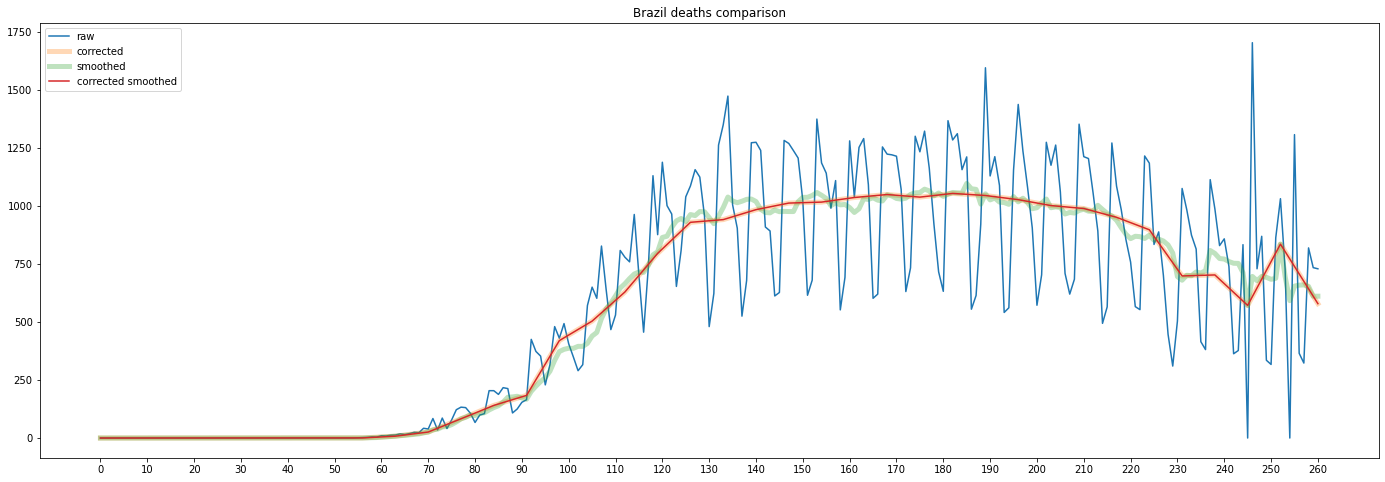

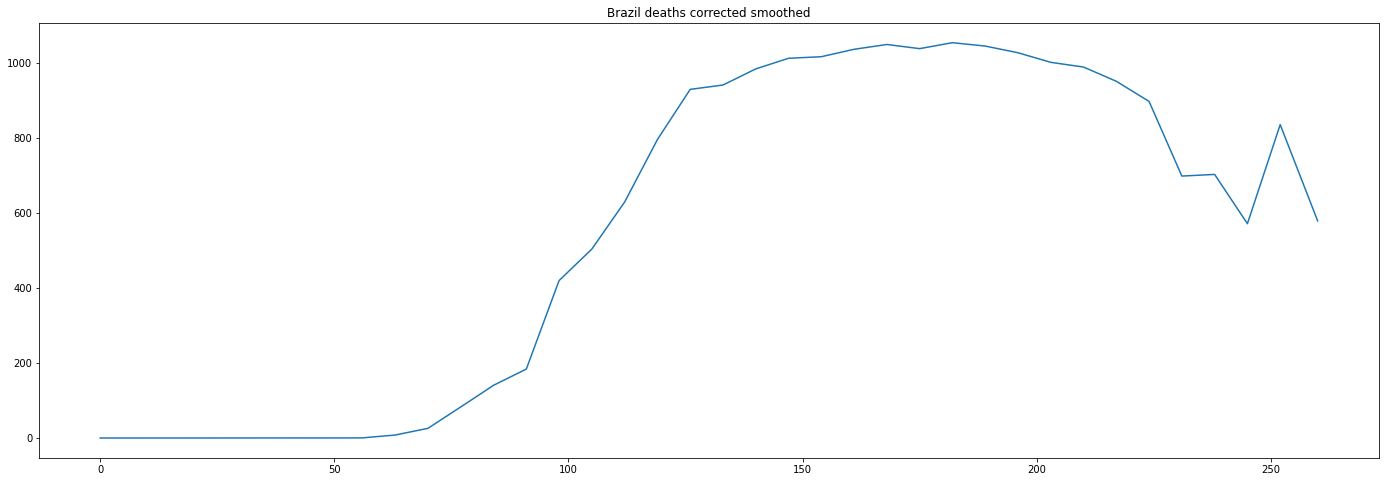

In [28]:
w = interact(plot_corrections(chosen_country,'deaths'))
display(w)

# ClusterFit testing

In [22]:
def plot_all2(countries,dat,adj=None,dat2=None,ndays=250):
    max_cols=6
    max_rows=int(len(countries)/max_cols) + 1
    fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,3.2*max_rows))

    for idx, country  in enumerate(countries):
        row = idx // max_cols
        col = idx % max_cols
        if max_rows>1:
            axes[row,col].plot(dat[country])
            axes[row,col].set_title(country)
            mx = np.max(dat[country])
            if adj is not None:   # assume same scale...
                axes[row,col].plot(adj[country],color = 'darkred', alpha=0.6)
                if np.max(adj[country]) > mx:
                    mx = np.max(adj[country])
            mn = 0.0
            axes[row,col].set_ylim((mn,mx))
            if dat2 is not None:
                ax = axes[row,col].twinx()
                ax.plot(dat2[country],color='black',linewidth=1,alpha=0.6)
                ax.set_ylim((0,max(dat2[country])))
        else:
            axes[col].plot(dat[country])
            axes[col].set_title(country)
            mx = np.max(dat[country])
            if adj is not None:   # assume same scale...
                axes[col].plot(adj[country],color = 'darkred', alpha=0.6)
                if np.max(adj[country]) > mx:
                    mx = np.max(adj[country])
            mn = 0.0
            axes[col].set_ylim((mn,mx))
            if dat2 is not None:
                ax = axes[col].twinx()
                ax.plot(dat2[country],color='black',linewidth=1,alpha=0.6)
                ax.set_ylim((0,max(dat2[country])))            
    if max_rows>1:
        for idx in range(len(countries),max_rows*max_cols):
            row = idx // max_cols
            col = idx % max_cols
            axes[row, col].axis("off")
    else:
        for idx in range(len(countries),max_cols):
            col = idx % max_cols
            axes[col].axis("off")            
    #plt.subplots_adjust(wspace=.05, hspace=.05)
    fig.tight_layout()
    #for ax in fig.get_axes():
    #    ax.label_outer()
    plt.show()


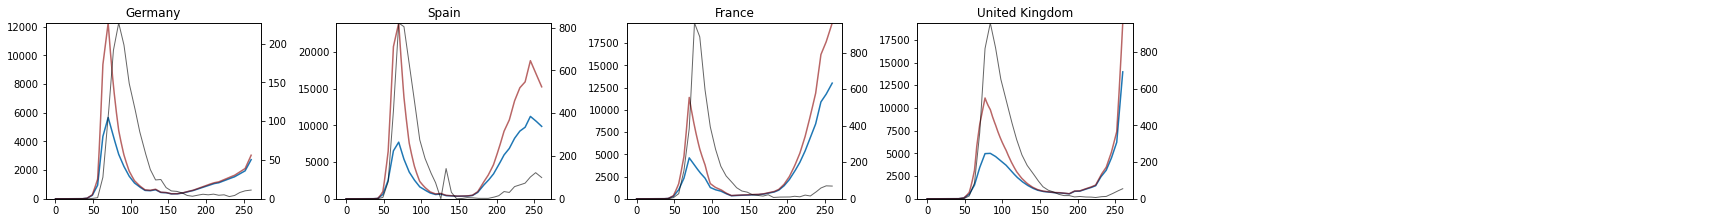

In [23]:
tst = ['Germany','Spain','France','United Kingdom']
plot_all2(tst,covid_owid_ts['new_confirmed_corrected_smoothed'],covid_owid_ts['new_confirmed_nonlinr_corrected_smoothed'],
          covid_owid_ts['new_deaths_corrected_smoothed'] )